### Step 1: Import Data with CoinPaprika API (https://api.coinpaprika.com/)

In [1]:
import Coinpaprika
import pandas as pd                        
from pytrends.request import TrendReq
import matplotlib.pyplot as plt

api_client = Coinpaprika.Client()
market_overview = api_client.global_market_overview()

#print(market_overview)

all_coins = api_client.coins()
for i  in range(0, 10):
    print(all_coins[i]['id'])

btc-bitcoin
eth-ethereum
bnb-binance-coin
xrp-xrp
usdt-tether
doge-dogecoin
ada-cardano
dot-polkadot
ltc-litecoin
bch-bitcoin-cash


## get historical data 

In [2]:
from datetime import datetime, timedelta

coin = 'btc-bitcoin'
color = 'green'

hist = api_client.coins.historical_OHLC(
    coin_id=coin,
    start=datetime.now() - timedelta(weeks=52) - timedelta(days=0),
    end=datetime.now() - timedelta(days=0)
)
# TODO: "clean up" data (na's, outliers, etc.)

In [3]:
def getNewsAverage(today):
    pytrends = TrendReq()

    kw_list = ["Bitcoin"]

    # get timeframe of last 28 days
    #today = hist[0]['time_open']
    new_date = today - timedelta(days=3)
    toString = today.strftime("%Y-%m-%d")
    fromString = new_date.strftime("%Y-%m-%d")
    timespan = fromString + " " + toString
    
    print(timespan)

    pytrends.build_payload(kw_list, cat=0, timeframe=timespan, geo='', gprop='')
    df = pytrends.interest_over_time()

    #return df;
    #return df['Bitcoin'][0];

    # calculate average
    average = 0
    for i in range(0, len(df['Bitcoin'])):
        average += df['Bitcoin'][i]
    average /= len(df['Bitcoin'])
    return average
    

In [4]:
alldata = []

for i in range(1,len(hist)):
    
    # difference closing yesterday to today
    pdct = hist[i]['close'] - hist[i-1]['close']
    
    alldata.append({
        "pdct": pdct,
        "variance": hist[i-1]['high'] - hist[i-1]['low'],
        "close": hist[i-1]['close'],
        "low": hist[i-1]['low'],
        "high": hist[i-1]['high'],
        "volume": hist[i-1]['volume']
    })

In [5]:
print(alldata[0])

{'pdct': -17.19636951999928, 'variance': 458.7706112300002, 'close': 8927.58887813, 'low': 8847.22904733, 'high': 9305.99965856, 'volume': 32894333585}


## Ziel: LinearRegression

In [6]:
close = []
for i in range(0, len(alldata)):
    close.append(alldata[i]['close'])

In [7]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor

# testdate: all except last week
numberOfTestData = 40

alldataFrame = pd.DataFrame(alldata)

feature_cols = ['volume', 'low', 'high', 'close', 'variance']
#feature_cols = ['pdctPositive', 'pdct', 'variance', 'volume', 'open', 'low', 'high']

X = alldataFrame[feature_cols]       # Features
y = alldataFrame['pdct']            # Target variable

X_train = X[:-numberOfTestData]
X_test  = X[-numberOfTestData:]
y_train = y[:-numberOfTestData]
y_test  = y[-numberOfTestData:]


# Create
lr = LinearRegression();

# Train
lr = lr.fit(X_train, y_train)

# Predict the response for test dataset
y_pred = lr.predict(X_test)

reg_metrics(y_test, y_pred, X_train)

numberCorrect = 0
numberFalse = 0

for i in range(0, numberOfTestData):
    valueInt = len(alldata)-(numberOfTestData)+i
    actualPDCT = alldata[valueInt]["pdct"]
    predictedPDCT = y_pred[i]
    
    actualPDCTPositive = actualPDCT > 0
    predictedPDCTPositive = predictedPDCT > 0
    
    if(actualPDCTPositive == predictedPDCTPositive):
        numberCorrect+=1
    else:
        numberFalse+=1
    #print("predicted: " + str(predictedPDCTPositive) + ", actual: " + str(actualPDCTPositive))
    
    
print(str(numberCorrect) + " / " + str((numberCorrect + numberFalse)))
#print(y_pred)


NameError: name 'reg_metrics' is not defined

In [ ]:
plotPDCTActual = []
plotPDCTPred = []

for i in range(0, numberOfTestData):
    valueInt = len(alldata)-(numberOfTestData)+i
    actualPDCT = alldata[valueInt]["pdct"]
    predictedPDCT = y_pred[i]
    
    plotPDCTActual.append(actualPDCT)
    plotPDCTPred.append(predictedPDCT)

plt.plot(plotPDCTActual, "blue")
plt.plot(plotPDCTPred, "red")
plt.grid(True)
plt.xlabel("Tage")
plt.show()

In [ ]:
def reg_metrics(y_test, y_pred, X_train):
    from sklearn.metrics import mean_squared_error, r2_score 

    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    r2 = r2_score(y_test,y_pred)

    # Scikit-learn doesn't have adjusted r-square, hence custom code
    n = y_pred.shape[0]
    k = X_train.shape[1]
    adj_r_sq = 1 - (1 - r2)*(n-1)/(n-1-k)

#    print(adj_r_sq)

In [ ]:
alldataFrame = pd.DataFrame(alldata) 
alldataFrame.head(6)

In [ ]:
alldataFrame.shape

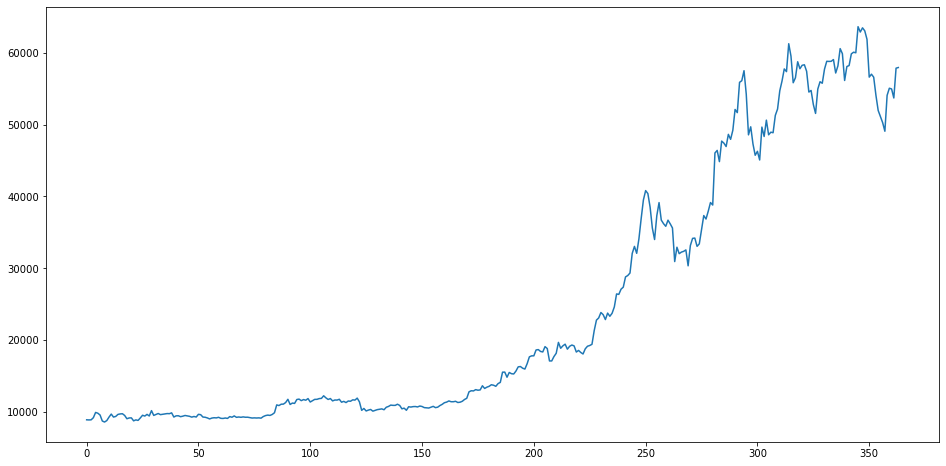

In [8]:
plt.figure(figsize=(16,8))
plt.plot(alldataFrame['close'])
plt.show()

In [57]:
alldataFrame = alldataFrame[['close']]

future_days = 25 # future days
alldataFrame['Prediction'] = alldataFrame[['close']].shift(-future_days)
#alldataFrame.tail(future_days)

In [58]:
from sklearn.model_selection import train_test_split
X = np.array(alldataFrame.drop(['Prediction'], 1))[:-future_days]
y = np.array(alldataFrame['Prediction'])[:-future_days]

# split data into 75% training and 25% testing
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.25)

In [59]:
#Create models
tree = DecisionTreeRegressor().fit(x_train, y_train)
lr = LinearRegression().fit(x_train, y_train)

#get last x rows
x_future = alldataFrame.drop(['Prediction'], 1)[:-future_days]
x_future = x_future.tail(future_days)
x_future = np.array(x_future)


In [1]:
# show
tree_prediction = tree.predict(x_future)

lr_prediction = lr.predict(x_future)
predictions = tree_prediction

valid = alldataFrame[X.shape[0]:]
valid['Prediction'] = predictions
plt.figure(figsize=(16,8))

plt.xlabel('Days')
plt.ylabel('Close')
plt.plot(alldataFrame['close'])
plt.plot(valid[['close', 'Prediction']])
plt.legend(['original values', 'actual values', 'predicted values'])
plt.show()

NameError: name 'tree' is not defined